这里把微信发来的base64图片数据解码成numpy的uint8数组

ipykernel_launcher:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


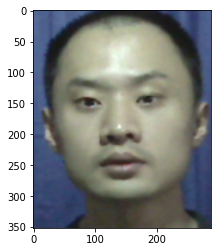

In [1]:
import base64
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import glob

with open('./data/imageBase64.txt','r') as f:
    file = f.readline()
image = base64.b64decode(file)
image = np.fromstring(image, np.uint8)
image = image.reshape([352,288,4])
image = image[:,:,:3]

# show image
imageShow = image / 255
plt.imshow(imageShow)

In [2]:
del f
del file
del imageShow

这里使用keras model实现人脸图片向量化

In [3]:
import tensorflow as tf
from keras.models import load_model
def loadKerasModel(file):
    model = load_model(file, compile=False)
    return model

def makeSquare(face):
    h,w,_ = face.shape
    if w>h:
        start = int((w-h)/2)
        end = start+h
        return face[:,start:end,:]
    else:
        start = int((h-w)/2)
        end = start+w
        return face[start:end,:,:]

def preprocess(face, required_size=(160, 160)):
    ret = makeSquare(face)
    ret = cv2.resize(face, required_size)
    #ret = cv2.cvtColor(ret, cv2.COLOR_BGR2RGB)
    ret = ret.astype('float32')
    # standardize pixel values across channels (global)
    ret = ret / 127.5 -1
    ret = ret.reshape([-1,*required_size,3])
    return ret

# load tfl model
keras_file = "./model/facenet_keras.h5"
keras_model = loadKerasModel(keras_file)

In [4]:
sample = preprocess(image)
embeddings = keras_model.predict(sample)

In [5]:
del sample
del embeddings
del keras_file

计算人脸图片向量化的时间，一次预测时间在85ms左右

In [6]:
def face_embedding():
    sample = preprocess(image)
    embeddings = keras_model.predict(sample)

In [7]:
%timeit face_embedding()

87.7 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
del image

比较人脸距离，查看模型准确度

In [9]:
def compare(path):
    imagePaths = glob.glob(path)
    print(','.join([path.split('\\')[-1] for path in imagePaths]))
    embs = []
    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        image = preprocess(image)
        emb = keras_model.predict(image)
        emb /= np.linalg.norm(emb, axis = 1, keepdims = True)
        embs.append(emb[0])
    embs = np.stack(embs)
    nrof_images = len(imagePaths)
    # Print distance matrix
    print('Distance matrix')
    print('    ', end='')
    for i in range(nrof_images):
        print('    %1d     ' % i, end='')
    print('')
    for i in range(nrof_images):
        print('%1d  ' % i, end='')
        for j in range(nrof_images):
            dist = np.sqrt(np.sum(np.square(np.subtract(embs[i,:], embs[j,:]))))
            print('  %1.4f  ' % dist, end='')
        print('')

比较相同人

In [10]:
compare('./data/image/*/000/*.png')
compare('./data/image/*/001/*.png')
compare('./data/image/*/002/*.png')

000_0000.png,000_0001.png,000_0002.png,000_0003.png,000_0004.png
Distance matrix
        0         1         2         3         4     
0    0.0000    0.4151    0.5870    0.9434    0.3754  
1    0.4151    0.0000    0.5858    0.8036    0.3689  
2    0.5870    0.5858    0.0000    0.7977    0.5884  
3    0.9434    0.8036    0.7977    0.0000    0.8644  
4    0.3754    0.3689    0.5884    0.8644    0.0000  
001_0000.png,001_0001.png,001_0002.png,001_0003.png,001_0004.png
Distance matrix
        0         1         2         3         4     
0    0.0000    0.4942    0.2088    0.4194    0.4951  
1    0.4942    0.0000    0.5092    0.5041    0.3910  
2    0.2088    0.5092    0.0000    0.4342    0.4925  
3    0.4194    0.5041    0.4342    0.0000    0.5385  
4    0.4951    0.3910    0.4925    0.5385    0.0000  
002_0000.png,002_0001.png,002_0002.png,002_0003.png,002_0004.png
Distance matrix
        0         1         2         3         4     
0    0.0000    0.3012    0.3994    0.2617    0.3056 

In [11]:
compare('./data/image/*/00*/*_0000.png')
compare('./data/image/*/01*/*_0000.png')
compare('./data/image/*/02*/*_0000.png')

000_0000.png,001_0000.png,002_0000.png,003_0000.png,004_0000.png,005_0000.png,006_0000.png,007_0000.png,008_0000.png,009_0000.png
Distance matrix
        0         1         2         3         4         5         6         7         8         9     
0    0.0000    1.0649    0.9815    0.9930    1.0125    1.1022    1.0809    1.0197    1.0217    1.2761  
1    1.0649    0.0000    0.9128    1.0048    1.0261    0.9370    0.7457    0.8549    0.7305    1.0425  
2    0.9815    0.9128    0.0000    0.8720    0.8462    0.8511    0.9272    0.6894    0.9214    1.0176  
3    0.9930    1.0048    0.8720    0.0000    0.8759    0.9761    1.0212    0.8544    0.9004    1.0100  
4    1.0125    1.0261    0.8462    0.8759    0.0000    0.9087    1.0391    0.8943    1.1255    0.9175  
5    1.1022    0.9370    0.8511    0.9761    0.9087    0.0000    0.9452    0.8280    0.8758    1.0121  
6    1.0809    0.7457    0.9272    1.0212    1.0391    0.9452    0.0000    0.8326    0.7358    1.0674  
7    1.0197    0.8549

把casia的500个人作为用户载入lmdb数据库中

In [12]:
import lmdb
import struct
def encode(key,vector):
    key = struct.pack('H',key)
    value = struct.pack('128f',*vector)
    return key,value
def decode(key, value):
    key = struct.unpack('H', key)
    vector = struct.unpack('128f',value)
    return key,vector
def writeEmbeddingsToLmdb(path):
    imagePaths = glob.glob(path)
    print(','.join([path.split('\\')[-1] for path in imagePaths]))
    embs = []
    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        image = preprocess(image)
        emb = keras_model.predict(image)
        emb /= np.linalg.norm(emb, axis = 1, keepdims = True)
        embs.append(emb[0])
    embs = np.stack(embs)
    with lmdb.open('./lmdb') as env:
        wfp = env.begin(write=True)
        for index,emb in enumerate(embs):
            key,value = encode(index, emb)
            wfp.put(key,value)
        wfp.commit()
writeEmbeddingsToLmdb('./data/image/*/00*/*_0000.png')

000_0000.png,001_0000.png,002_0000.png,003_0000.png,004_0000.png,005_0000.png,006_0000.png,007_0000.png,008_0000.png,009_0000.png


In [13]:
def printAllFromLmdb():
    with lmdb.open('./lmdb') as env:
        wfp = env.begin()
        for key,value in wfp.cursor():
            print(decode(key,value))
printAllFromLmdb()

264760866761208, 0.04714815691113472, -0.004921269603073597, -0.03937603533267975, -0.0267486609518528, 0.1351977288722992, 0.04179186001420021, -0.03288891911506653, 0.052371520549058914, 0.054816052317619324, -0.15315940976142883, 0.11996275931596756, -0.013554125092923641, 0.061997924000024796, 0.09256884455680847, 0.04362655058503151, 0.10215679556131363, 0.08004883676767349, 0.14403578639030457, -0.1962834596633911, 0.00410510553047061, -0.07943098992109299))
((3,), (0.1139584332704544, -0.14594008028507233, -0.07406331598758698, 0.04543847218155861, 0.015818875283002853, -0.019646471366286278, 0.05775473266839981, -0.1297886222600937, 0.11583305895328522, 0.01316129881888628, -0.027473319321870804, 0.03129087761044502, -0.05767327919602394, -0.2024059146642685, 0.014738762751221657, -0.16746649146080017, 0.10110341012477875, 0.02378339320421219, -0.029967233538627625, -0.07559651136398315, 0.028673270717263222, -0.0749611034989357, -0.12108369916677475, -0.09997940063476562, 0.12

把lmdb数据创建annoy索引

In [19]:
from annoy import AnnoyIndex
def createAnnoyIndex():
    annoy = AnnoyIndex(128, metric='angular')
    with lmdb.open('./lmdb') as env:
        wfp = env.begin()
        for key, value in wfp.cursor():
            key,vector = decode(key,value)
            annoy.add_item(key[0],vector)
    annoy.build(10)
    if not os.path.exists('./annoyIndex/'):
        os.mkdir('./annoyIndex/')
    annoy.save('./annoyIndex/face_vector.nn')
    print('create annoy index successfully')

createAnnoyIndex()

create annoy index successfully


测试准确度

In [20]:
def evaluate(path):
    imagePaths = glob.glob(path)
    print(','.join([path.split('\\')[-1] for path in imagePaths]))
    embs = []
    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        image = preprocess(image)
        emb = keras_model.predict(image)
        emb /= np.linalg.norm(emb, axis = 1, keepdims = True)
        embs.append(emb[0])
    embs = np.stack(embs)
    # 载入annoy索引数据
    annoy = AnnoyIndex(128, metric='angular')
    annoy.load('./annoyIndex/face_vector.nn')
    for e in embs:
        res = annoy.get_nns_by_vector(e,5,include_distances=True)
        print(res)
evaluate('./data/image/*/00*/*_0001.png')
evaluate('./data/image/*/00*/*_0002.png')
evaluate('./data/image/*/00*/*_0003.png')

000_0001.png,001_0001.png,002_0001.png,003_0001.png,004_0001.png,005_0001.png,006_0001.png,007_0001.png,008_0001.png,009_0001.png
([0, 2, 7, 4, 6], [0.4150976240634918, 0.87148118019104, 0.9077237844467163, 0.9102727174758911, 0.9345104098320007])
([1, 6, 8, 7, 5], [0.494213342666626, 0.7344674468040466, 0.899582028388977, 0.9539015293121338, 0.9736462831497192])
([2, 7, 6, 4, 1], [0.3012036383152008, 0.6487978100776672, 0.8476768732070923, 0.8610010147094727, 0.8689799308776855])
([3, 2, 7, 4, 0], [0.5449944734573364, 0.8286476731300354, 0.8642733693122864, 0.8844331502914429, 0.950388491153717])
([4, 2, 7, 3, 9], [0.4868563413619995, 0.7731329798698425, 0.8361685872077942, 0.86062091588974, 0.8713366389274597])
([5, 8, 2, 6, 7], [0.4490931034088135, 0.8487934470176697, 0.8676172494888306, 0.8689197301864624, 0.8749685287475586])
([6, 1, 7, 2, 8], [0.6005072593688965, 0.7598192691802979, 0.785875678062439, 0.7906040549278259, 0.8266005516052246])
([7, 2, 6, 1, 8], [0.3378082513809204,